In [74]:
from _tests import scripts
from scripts.notebook_utils import *

In [75]:
ARCH_PATH = "/home/workspace/models/arch/1_macro/dummy/arch.yaml"

def run_basic_analog_spec(array_rows: int, array_columns: int):
    # Load in the specification
    spec = get_spec("dummy")

    # Enable the MAX_UTILIZATION variable. This will generate a
    # workload that maximizes the utilization of the array.
    spec.variables["MAX_UTILIZATION"] = True

    # Set the number of rows and columns in the array
    #spec.architecture.find("weight_modulators").attributes.n_instances = 24
    #spec.architecture.find("IMU").spatial.meshX = 1
    #spec.architecture.find("input_modulator").spatial.meshY = array_rows

    return run_mapper_parse_output(spec, "my_spec")


results = run_basic_analog_spec(array_rows=24, array_columns=24)
print(f"Total Energy (pJ): {results.total_energy:.2f}")
print(f"Total Area (mm^2): {results.total_area / 1000000:.2f}")
print(f"Number of MACs: {results.macs:.2f}")
print(f"Compute Density (TOPS/mm^2): {results.tops_per_mm2:.2f}")
print(f"Energy Efficiency (TOPS/W): {results.tops_per_w:.2f}")

Total Energy (pJ): 942.31
Total Area (mm^2): 1936.65
Number of MACs: 576.00
Compute Density (TOPS/mm^2): 0.00
Energy Efficiency (TOPS/W): 1.22


In [76]:
display_markdown("# Architectural Diagram")

# Architectural Diagram

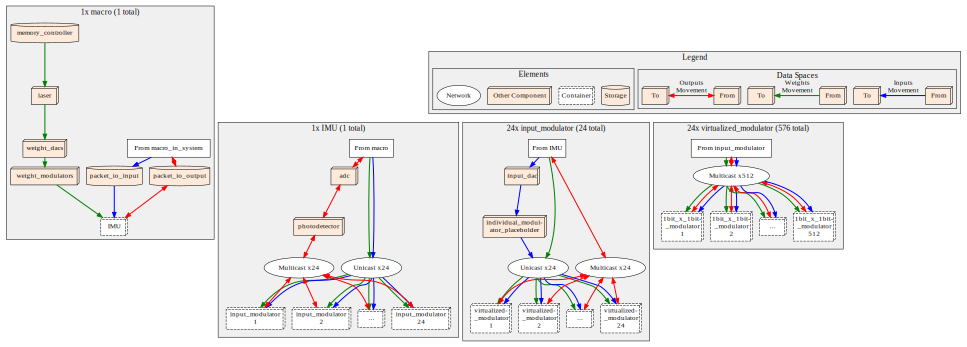

In [77]:
display_diagram(get_diagram("dummy", ["macro", "IMU", "input_modulator", "virtualized_modulator"]))

In [78]:
display_markdown("# Area Breakdown")

# Area Breakdown


   This test replicates the results for area presented in Table2 of the Lightning paper. We show the area for the Packet       I/O, Memory Controller, DAC, ADC, Modulator, Photodetector and Laser. Our results match perfectly the contents of the       Table2 in the Lightning paper. 

   Lightning's area is dominated by the optical modulators and the DACs
   

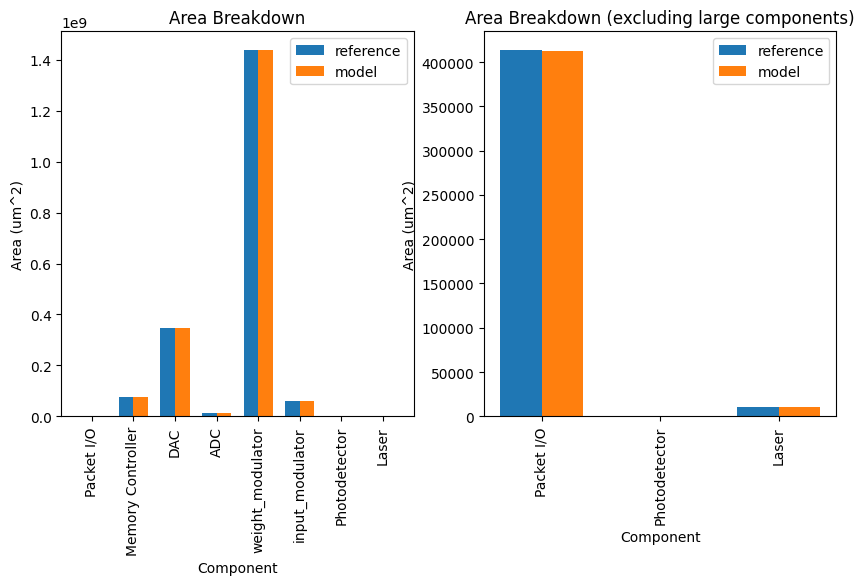

In [81]:
result = run_test("dummy", "test_area_breakdown")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
bar_side_by_side(
    result[0].get_compare_ref_area(),
    xlabel="Component",
    ylabel="Area (um^2)",
    title=f"Area Breakdown",
    ax=ax[0],
)

for big_component in ["weight_modulator", "input_modulator", "DAC", "ADC", "Memory Controller"]:
    del result[0].area[big_component]

bar_side_by_side
bar_side_by_side(
    result[0].get_compare_ref_area(),
    xlabel="Component",
    ylabel="Area (um^2)",
    title=f"Area Breakdown (excluding large components)",
    ax=ax[1],
)

In [82]:
display_markdown("# Energy Breakdown")

# Energy Breakdown


   This test replicates the results presented in Table III of the Albireo
   paper. We show the energy the MRR, MZM, Laser, TIA, DAC, ADC, and Cache.
   Results are shown assuming three levels of future technology scaling:
   conservative (high energy), moderate (medium energy), and aggressive (low
   energy).

   Albireo's energy primarily is consumed by DACs and MRRs. High MRR energy is
   because Albireo uses a large array of MRRs. High DAC energy is because
   Albireo requires many DAC converts for weights because analog-electrical
   weights are only reused for 5 MACs each (low MACs/convert, see the RAELLA
   paper Titanium law).
   

100%|██████████| 1/1 [00:10<00:00, 10.88s/it]


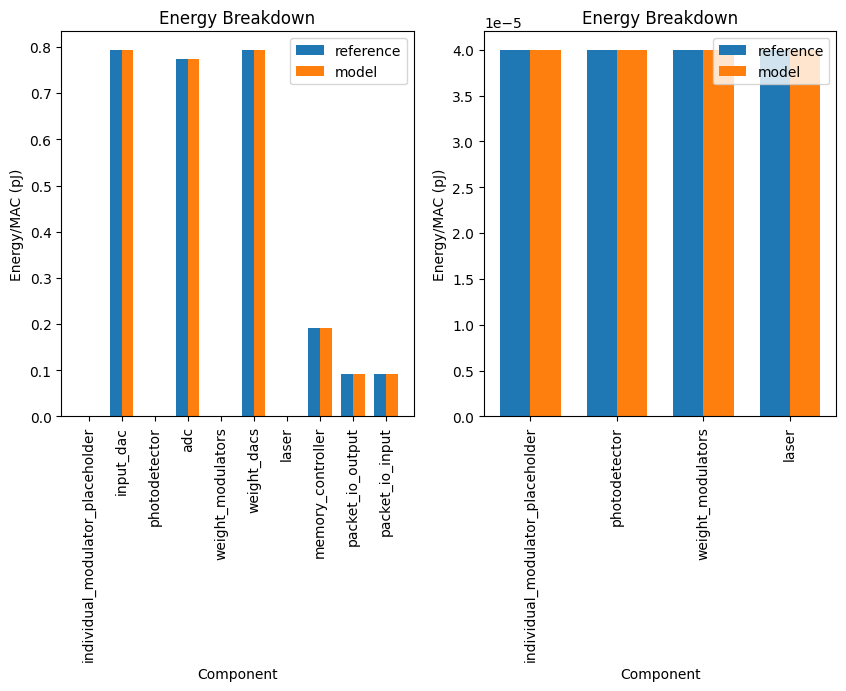

In [99]:
result = run_test("dummy", "test_energy_breakdown")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
bar_side_by_side(
    result[0].get_compare_ref_energy(),
    xlabel="Component",
    ylabel="Energy/MAC (pJ)",
    title=f"Energy Breakdown",
    ax=ax[0],
)

for big_component in ["input_dac", "adc", "weight_dacs", "memory_controller", "packet_io_input", "packet_io_output"]:
    del result[0].energy[big_component]

bar_side_by_side
bar_side_by_side(
    result[0].get_compare_ref_energy(),
    xlabel="Component",
    ylabel="Energy/MAC (pJ)",
    title=f"Energy Breakdown",
    ax=ax[1],
)

In [66]:
display_markdown("# Running DNN Models")

# Running DNN Models


   ### Full-DNN Energy Efficiency and Throughput

   This test explores the throughput and energy efficiency of the accelerator
   for different DNN layers and batch sizes. Looking at the results for the
   batch size of 1, we can see the following:

   - Albireo has low throughput for the fully-connected layers of all DNNs
     (last three layers of AlexNet, last two layers of VGG16, and last layer of
     ResNet18). This is because Albireo is optimized for convolutional layers
     and is underutilized when running fully-connected layers. This being said,
     if we look at the total latency and energy of each layer, we can see that
     fully-connected layers are not significant contributors to the overall
     energy and latency for VGG16 and ResNet18, so this underutilization has a
     smaller impact. However, for AlexNet, the fully-connected layers are
     significant contributors to the overall energy and latency, so this
     underutilization has a larger impact.
   - VGG16 has consistently high throughput for convolutional layers. This is
     because VGG16 uses large weight tensors and convolutional strides of one,
     which allows Albireo to achieve high utilization.
   - AlexNet and ResNet18 have lower throughput for convolutional layers. This
     is due to two factors. First, they often use convolutional strides larger
     than one, for which Albireo is not optimized and becomes underutilized.
     Second, their weight tensor sizes vary more than do those of VGG16, and
     small weight tensors sometimes results in underutilization. These effects
     can be seen especially in ResNet18 layers 7, 12, and 17, which have
     one-wide convolutional filters (R=S=1) that result in severe
     underutilization.

   We can also see that throughput and energy efficiency are correlated because
   underutilization both decreases throughput and increases energy. Energy
   efficiency generally varies less than does throughput because
   underutilization results in fewer activations of some componoents, which can
   somewhat offset the increased energy due to underutilization.

   The batch size of 8 shows similar trends, but the effect of underutilization
   is not as severe because we can increase utilization in some cases by
   running multiple inputs in parallel.

   We note that observing per-layer breakdowns in this way can be a valuable
   tool to understand what causes energy and/or throughput differences across
   full DNNs.
   

100%|██████████| 16/16 [01:48<00:00,  6.75s/it]


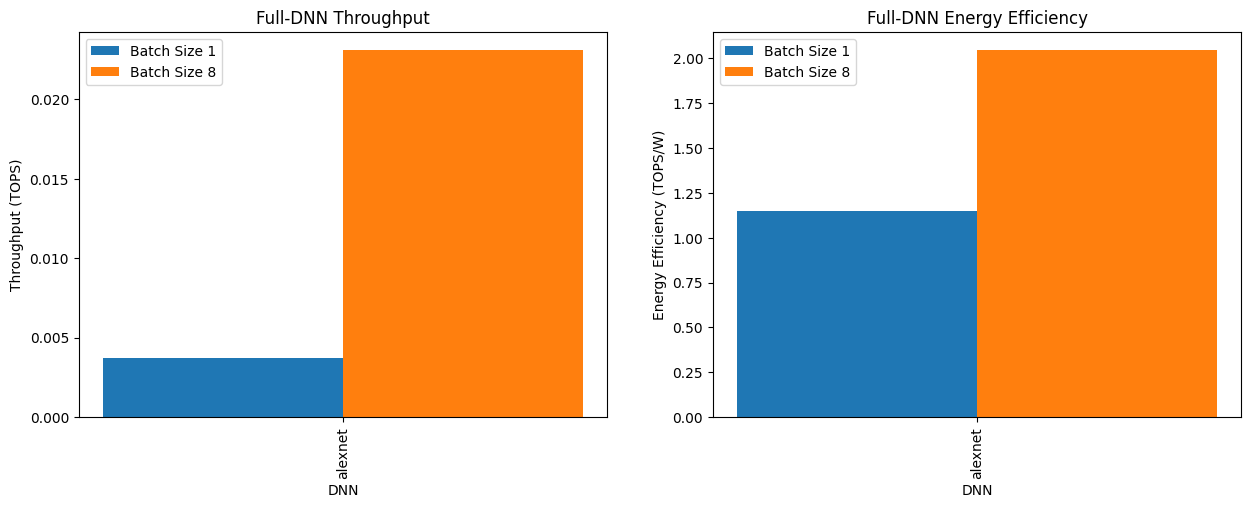

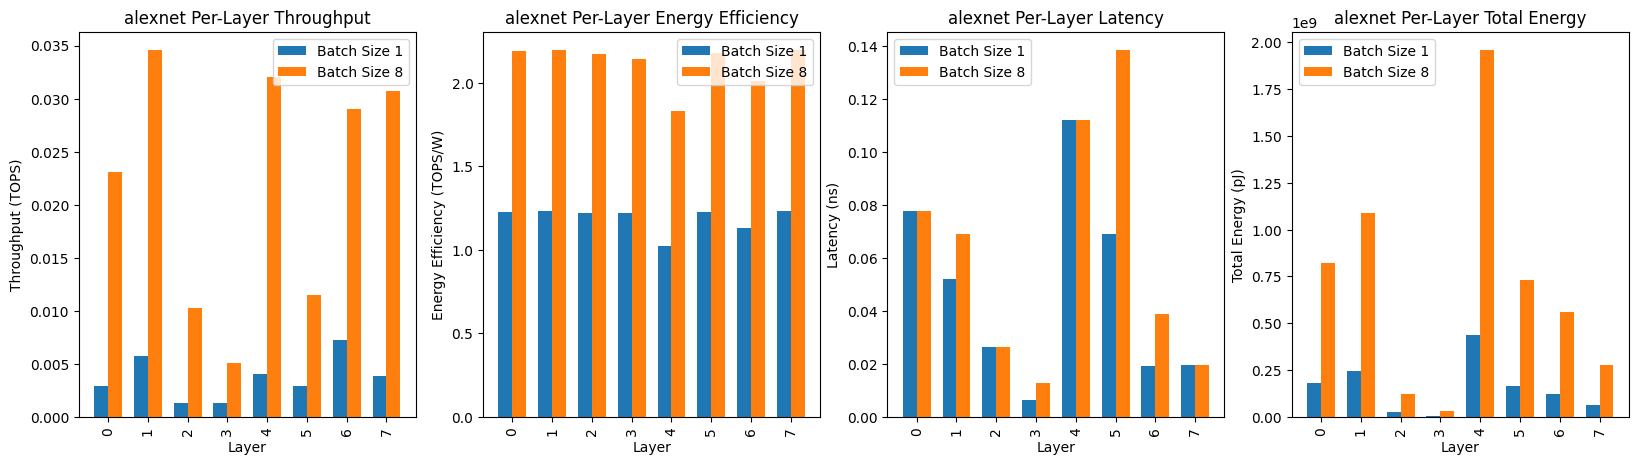

In [71]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
results = {}
for i, dnn in enumerate(["alexnet"]):
    results[dnn] = run_test(
        "dummy", "test_full_dnn", dnn_name=dnn, show_doc=i == 0
    )


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

tops, tops_per_w = {}, {}

# Full-DNN results
for dnn, r in results.items():
    tops[dnn], tops_per_w[dnn] = {}, {}
    for r2 in r.aggregate_by("BATCH_SIZE"):
        batch_size = f'Batch Size {r2.variables["BATCH_SIZE"]}'
        tops[dnn][batch_size] = r2.tops
        tops_per_w[dnn][batch_size] = r2.tops_per_w

for ax, data, title, ylabel in [
    (axs[0], tops, "Throughput", "TOPS"),
    (axs[1], tops_per_w, "Energy Efficiency", "TOPS/W"),
]:
    bar_side_by_side(
        data,
        xlabel="DNN",
        ylabel=f"{title} ({ylabel})",
        title=f"Full-DNN {title}",
        ax=ax,
    )

# Per-Layer Results
for dnn, result in results.items():
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for ax, attrname, title, ylabel in [
        (ax[0], "tops", "Throughput", "TOPS"),
        (ax[1], "tops_per_w", "Energy Efficiency", "TOPS/W"),
        (ax[2], "latency", "Latency", "ns"),
        (ax[3], "total_energy", "Total Energy", "pJ"),
    ]:
        per_layer_results = {}
        for j, same_layers in enumerate(zip(*result.split_by("BATCH_SIZE"))):
            per_layer_results[j] = {
                f'Batch Size {r.variables["BATCH_SIZE"]}': getattr(r, attrname)
                for r in same_layers
            }
        bar_side_by_side(
            per_layer_results,
            xlabel="Layer",
            ylabel=f"{title} ({ylabel})",
            title=f"{dnn} Per-Layer {title}",
            ax=ax,
        )

In [68]:
diff = 1.5018077 - 1.6368923611
per = 1.6368923611 / 1.5018077
print("Energy difference per MAC is", abs(diff), 'pj')
print ("This is a deviation of", per, "%")

Energy difference per MAC is 0.13508466109999984 pj
This is a deviation of 1.0899480413504337 %


In [69]:
display_markdown("# Resnet")

# Resnet

In [70]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
results = {}
for i, dnn in enumerate(["resnet18"]):
    results[dnn] = run_test(
        "dummy", "test_full_dnn", dnn_name=dnn, show_doc=i == 0
    )


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

tops, tops_per_w = {}, {}

# Full-DNN results
for dnn, r in results.items():
    tops[dnn], tops_per_w[dnn] = {}, {}
    for r2 in r.aggregate_by("BATCH_SIZE"):
        batch_size = f'Batch Size {r2.variables["BATCH_SIZE"]}'
        tops[dnn][batch_size] = r2.tops
        tops_per_w[dnn][batch_size] = r2.tops_per_w

for ax, data, title, ylabel in [
    (axs[0], tops, "Throughput", "TOPS"),
    (axs[1], tops_per_w, "Energy Efficiency", "TOPS/W"),
]:
    bar_side_by_side(
        data,
        xlabel="DNN",
        ylabel=f"{title} ({ylabel})",
        title=f"Full-DNN {title}",
        ax=ax,
    )

# Per-Layer Results
for dnn, result in results.items():
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for ax, attrname, title, ylabel in [
        (ax[0], "tops", "Throughput", "TOPS"),
        (ax[1], "tops_per_w", "Energy Efficiency", "TOPS/W"),
        (ax[2], "latency", "Latency", "ns"),
        (ax[3], "total_energy", "Total Energy", "pJ"),
    ]:
        per_layer_results = {}
        for j, same_layers in enumerate(zip(*result.split_by("BATCH_SIZE"))):
            per_layer_results[j] = {
                f'Batch Size {r.variables["BATCH_SIZE"]}': getattr(r, attrname)
                for r in same_layers
            }
        bar_side_by_side(
            per_layer_results,
            xlabel="Layer",
            ylabel=f"{title} ({ylabel})",
            title=f"{dnn} Per-Layer {title}",
            ax=ax,
        )


   ### Full-DNN Energy Efficiency and Throughput

   This test explores the throughput and energy efficiency of the accelerator
   for different DNN layers and batch sizes. Looking at the results for the
   batch size of 1, we can see the following:

   - Albireo has low throughput for the fully-connected layers of all DNNs
     (last three layers of AlexNet, last two layers of VGG16, and last layer of
     ResNet18). This is because Albireo is optimized for convolutional layers
     and is underutilized when running fully-connected layers. This being said,
     if we look at the total latency and energy of each layer, we can see that
     fully-connected layers are not significant contributors to the overall
     energy and latency for VGG16 and ResNet18, so this underutilization has a
     smaller impact. However, for AlexNet, the fully-connected layers are
     significant contributors to the overall energy and latency, so this
     underutilization has a larger impact.
   - VGG16 has consistently high throughput for convolutional layers. This is
     because VGG16 uses large weight tensors and convolutional strides of one,
     which allows Albireo to achieve high utilization.
   - AlexNet and ResNet18 have lower throughput for convolutional layers. This
     is due to two factors. First, they often use convolutional strides larger
     than one, for which Albireo is not optimized and becomes underutilized.
     Second, their weight tensor sizes vary more than do those of VGG16, and
     small weight tensors sometimes results in underutilization. These effects
     can be seen especially in ResNet18 layers 7, 12, and 17, which have
     one-wide convolutional filters (R=S=1) that result in severe
     underutilization.

   We can also see that throughput and energy efficiency are correlated because
   underutilization both decreases throughput and increases energy. Energy
   efficiency generally varies less than does throughput because
   underutilization results in fewer activations of some componoents, which can
   somewhat offset the increased energy due to underutilization.

   The batch size of 8 shows similar trends, but the effect of underutilization
   is not as severe because we can increase utilization in some cases by
   running multiple inputs in parallel.

   We note that observing per-layer breakdowns in this way can be a valuable
   tool to understand what causes energy and/or throughput differences across
   full DNNs.
   

 21%|██▏       | 9/42 [03:52<14:11, 25.81s/it]   


KeyboardInterrupt: 